In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from torch.linalg import norm
from sklearn.linear_model import LinearRegression
from dataset_HR import AdSBHDataset
from model_HR_new import AdSBHNet
from constants import dreal, dcomplex

# Import dataset

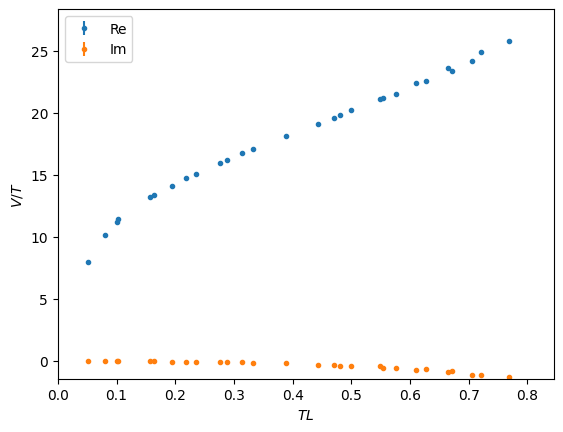

In [2]:
dataset = AdSBHDataset(file='1607latticeT113.txt') 
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

Right now we can't solve for the `curve` for that high $T L$ so we'll drop some data points.

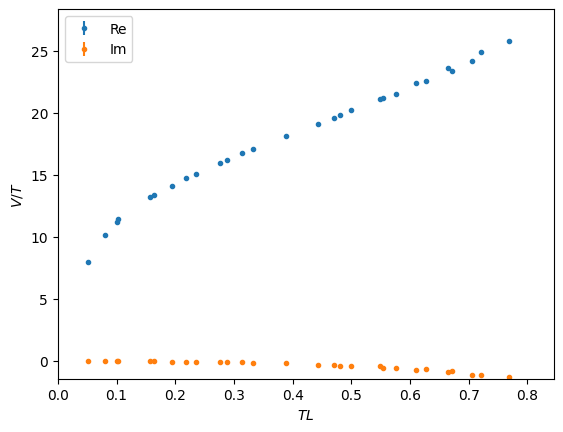

In [3]:
dataset.V = dataset.V[dataset.L < 1]
dataset.sigma = dataset.sigma[dataset.L < 1]
dataset.L = dataset.L[dataset.L < 1]
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

# Model and baseline

In [4]:

model = AdSBHNet(N=4, std=0.3) 
device = dataset.L.device
model.to(device)

# start from pure AdS-BH: a=b=0, coef=1, shift=0
with torch.no_grad():
    model.a.zero_()
    model.b.zero_()
    model.logcoef.fill_(0.0)   # exp(0)=1
    model.shift.fill_(0.0)

print("Fresh model:")
print("  a =", model.a.detach().cpu().numpy())
print("  b =", model.b.detach().cpu().numpy())
print(f"  coef = {model.logcoef.exp().item():.3f}, shift = {model.shift.item():.3f}")


Fresh model:
  a = [0. 0. 0. 0.]
  b = [0. 0. 0. 0.]
  coef = 1.000, shift = 0.000


# Helper functions

In [5]:
@torch.no_grad()
def connected_branch(model, zmin=0.02, zmax=0.9995, Nc=2500):
    dev, dt = model.a.device, model.a.dtype
    zs = torch.linspace(zmin, zmax, Nc, dtype=dt, device=dev)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real
    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]
    imax = torch.argmax(Lc)
    return Lc[:imax+1], Vc[:imax+1]


@torch.no_grad()
def _interp_1d(x, y, xq, eps=1e-12):
    
    dt, dev = x.dtype, x.device
    xq = torch.as_tensor(xq, dtype=dt, device=dev).reshape(-1)

    pos = torch.searchsorted(x, xq, right=True)
    i0 = (pos-1).clamp(0, x.numel()-2); i1 = i0+1
    x0, x1 = x[i0], x[i1]
    y0, y1 = y[i0], y[i1]

    w    = (xq - x0) / (x1 - x0 + eps)
    v_lin = y0 + w*(y1-y0)

    mL = (y[1]-y[0]) / (x[1]-x[0] + eps)
    mR = (y[-1]-y[-2]) / (x[-1]-x[-2] + eps)

    v_left  = y[0]  + mL*(xq - x[0])
    v_right = y[-1] + mR*(xq - x[-1])

    v = torch.where(xq <  x[0],  v_left,  v_lin)
    v = torch.where(xq >  x[-1], v_right, v)
    return v


def V_of_L_interp_real(model, L_query,
                       zmin=0.02, zmax=0.9997, zs_num=4000, q=2.7, eps=1e-12):
   
    dev, dt = model.a.device, model.a.dtype
    Lq = torch.as_tensor(L_query, dtype=dt, device=dev).reshape(-1)

    # sample zs grid (biased towards horizon)
    u  = torch.linspace(0.0, 1.0, zs_num, dtype=dt, device=dev)
    zs = zmin + (zmax - zmin) * (u**q)

    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real

    # sort by L and keep increasing part
    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]
    dL = torch.diff(Lc)
    keep = torch.cat([torch.tensor([True], device=dev), dL > 0])
    Lm, Vm = Lc[keep], Vc[keep]

    if Lm.numel() < 2:             # safety fallback
        Lm, Vm = Lc, Vc

    # interpolation + extrapolation
    pos = torch.searchsorted(Lm, Lq, right=True)
    i0 = (pos-1).clamp(0, Lm.numel()-2)
    i1 = i0+1
    x0, x1 = Lm[i0], Lm[i1]
    y0, y1 = Vm[i0], Vm[i1]

    w     = (Lq - x0) / (x1 - x0 + eps)
    v_lin = y0 + w*(y1-y0)

    mL = (Vm[1]-Vm[0])   / (Lm[1]-Lm[0]   + eps)
    mR = (Vm[-1]-Vm[-2]) / (Lm[-1]-Lm[-2] + eps)

    v_left  = Vm[0]  + mL*(Lq - Lm[0])
    v_right = Vm[-1] + mR*(Lq - Lm[-1])

    v = torch.where(Lq <  Lm[0],  v_left,  v_lin)
    v = torch.where(Lq >  Lm[-1], v_right, v)

    return v, (Lm[0].detach(), Lm[-1].detach())


def smoothness_C2(val_fn, z):
   
    v = val_fn(z)
    d2 = v[:-2] - 2*v[1:-1] + v[2:]
    return (d2.real**2).mean()


def uv_horizon_penalty(model):
    z0 = torch.tensor(1e-3,  dtype=model.a.dtype, device=model.a.device)
    zh = torch.tensor(0.995, dtype=model.a.dtype, device=model.a.device)

    f0   = model.eval_f(z0)
    g0   = model.eval_g(z0)
    fhor = model.eval_f(zh)

    def _r2(t, target):
        if torch.is_complex(t):
            return (t.real - target)**2 + t.imag**2
        else:
            return (t - target)**2

    return _r2(f0, 1.0) + _r2(g0, 1.0) + _r2(fhor, 0.0)

@torch.no_grad()
def find_turning_point(model, zmin=0.02, zmax=0.9995, Nc=2500):
    
    dev, dt = model.a.device, model.a.dtype
    zs  = torch.linspace(zmin, zmax, Nc, dtype=dt, device=dev)
    Lc  = model.integrate_L(zs).real
    imax = torch.argmax(Lc)
    return zs[imax].item(), Lc[imax].item()


def newton_complex_zs(model, L_target, z_init, max_steps=30, tol=1e-10, h=1e-3, max_step=0.2):
    
    z = complex(z_init)
    for _ in range(max_steps):
        # current L(z)
        Lz_t = model.integrate_L(z)
        Lz   = complex(Lz_t.item())

        # derivative dL/dz
        if hasattr(model, "integrate_dL"):
            dL_t = model.integrate_dL(z)
            dL   = complex(dL_t.item())
        else:
            Lp = complex(model.integrate_L(z + h).item())
            Lm = complex(model.integrate_L(z - h).item())
            dL = (Lp - Lm) / (2.0*h)

        if abs(dL) < 1e-14 or not np.isfinite(dL.real) or not np.isfinite(dL.imag):
            break

        step = (Lz - L_target) / dL
        # clamp step size
        if abs(step) > max_step:
            step = max_step * step / abs(step)

        z_new = z - step

        # clamp region where we allow z_* to live
        zr, zi = z_new.real, z_new.imag
        zr = min(max(zr, 1e-4), 1.5)
        zi = min(max(zi, -1.0), 1.0)   # allow both positive and negative Im
        z_new = complex(zr, zi)

        if abs(z_new - z) < tol:
            z = z_new
            break
        z = z_new

    return z


def newton_zs_for_L(model, L_target, init, maxit=40, tol=1e-10, h=1e-4):
    
    zs = complex(init)
    for _ in range(maxit):
        Lz = complex(model.integrate_L(zs).item())
        Lp = complex(model.integrate_L(zs + h).item())
        Lm = complex(model.integrate_L(zs - h).item())
        dL = (Lp - Lm) / (2.0*h)
        if abs(dL) < 1e-14:
            break
        step = (Lz - L_target) / dL
        # mild step clipping to stay on same branch
        if abs(step) > 0.4:
            step *= 0.4 / abs(step)
        zs -= step
        if abs(step) < tol:
            break
    return zs



# Initialization 

In [6]:
# Initialize model with small random perturbations
model = AdSBHNet(N=4, std=0.0)

# Initialize parameters close to zero (baseline AdS-BH)
with torch.no_grad():
    model.a.normal_(0.0, 0.1)
    model.b.normal_(0.0, 0.05)
    model.logcoef.copy_(torch.tensor(0.0, dtype=model.logcoef.dtype))
    model.shift.copy_(torch.tensor(0.0, dtype=model.shift.dtype))

print("Model initialized:")
print(f"  a = {model.a.detach().cpu().numpy()}")
print(f"  b = {model.b.detach().cpu().numpy()}")
print(f"  coef = {model.logcoef.exp().item():.6g}")
print(f"  shift = {model.shift.item():.4f}")

Model initialized:
  a = [-0.06712006 -0.06378146 -0.04280176  0.07350668]
  b = [-0.06414193 -0.06021205 -0.08164924  0.01430803]
  coef = 1
  shift = 0.0000


# Training

In [7]:
# Training loop - optimize a and b to match real part of data
# Allow shift to be optimized to match the data offset
optimizer = torch.optim.Adam([
    {'params': [model.a, model.b], 'lr': 0.005},
    {'params': [model.shift], 'lr': 0.01},
    {'params': [model.logcoef], 'lr': 0.001}
], lr=0.005)

# Only use real part of data
L_data = dataset.L
V_data_real = dataset.V.real
sigma_data_real = dataset.sigma.real

# Training parameters
num_epochs = 3000
print_interval = 100
snap_interval = 100

# Storage for tracking training progress
snap_a = []
snap_b = []
loss_history = []
rmse_history = []

print("Starting training to fit Re(V) only...")
print(f"Data points: {len(L_data)}")
print(f"L range: [{L_data.min().item():.3f}, {L_data.max().item():.3f}]")
print(f"V range: [{V_data_real.min().item():.3f}, {V_data_real.max().item():.3f}]")
print()

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass: compute V(L) for each data point using the interpolator
    V_pred = model(L_data).real  # Only use real part (includes shift)
    
    # Weighted MSE loss (weighted by inverse of uncertainty)
    weights = 1.0 / (sigma_data_real**2 + 1e-6)
    loss = torch.mean(weights * (V_pred - V_data_real)**2)
    
    # Compute RMSE for monitoring
    with torch.no_grad():
        rmse = torch.sqrt(torch.mean((V_pred - V_data_real)**2))
        rmse_history.append(rmse.item())
        loss_history.append(loss.item())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Snapshot parameters for visualization
    if epoch % snap_interval == 0:
        snap_a.append(model.a.detach().cpu().numpy().copy())
        snap_b.append(model.b.detach().cpu().numpy().copy())
    
    # Print progress
    if epoch % print_interval == 0:
        print(f"Epoch {epoch:4d}/{num_epochs}: Loss = {loss.item():.6f}, RMSE = {rmse.item():.4f}, shift = {model.shift.item():.4f}")
        if epoch % (print_interval * 2) == 0:
            print(f"  a = {model.a.detach().cpu().numpy()}")
            print(f"  b = {model.b.detach().cpu().numpy()}")
            print(f"  coef = {model.logcoef.exp().item():.6g}")

# Final snapshot
snap_a.append(model.a.detach().cpu().numpy().copy())
snap_b.append(model.b.detach().cpu().numpy().copy())

print("\nTraining complete!")
print(f"\nFinal parameters:")
print(f"  a = {model.a.detach().cpu().numpy()}")
print(f"  b = {model.b.detach().cpu().numpy()}")
print(f"  shift = {model.shift.item():.4f}")
print(f"  coef = {model.logcoef.exp().item():.6g}")
print(f"  Final loss = {loss.item():.6f}")
print(f"  Final RMSE = {rmse.item():.4f}")

Starting training to fit Re(V) only...
Data points: 28
L range: [0.051, 0.768]
V range: [7.988, 25.783]

Epoch    0/3000: Loss = 260413236.254207, RMSE = 1009.1067, shift = 0.0100
  a = [-0.06212006 -0.05878146 -0.03780176  0.07850668]
  b = [-0.05914193 -0.05521205 -0.07664924  0.00930803]
  coef = 0.999
Epoch  100/3000: Loss = 7441487.642121, RMSE = 29.4364, shift = 0.9586
Epoch  200/3000: Loss = 6590326.872793, RMSE = 15.9823, shift = 1.9016
  a = [-0.01792197 -0.0158159   0.00461321  0.12049836]
  b = [-0.01477394 -0.01191319 -0.03357854 -0.01459207]
  coef = 0.97022
Epoch  300/3000: Loss = 5996611.272041, RMSE = 14.7753, shift = 2.8313
Epoch  400/3000: Loss = 8463803.881526, RMSE = 119.7667, shift = 3.7483
  a = [-0.01219062 -0.01187243  0.00804468  0.12400988]
  b = [-0.00888811 -0.00768446 -0.02950788  0.02130421]
  coef = 0.940101
Epoch  500/3000: Loss = 4841906.754449, RMSE = 14.3116, shift = 4.6419
Epoch  600/3000: Loss = 4310091.892320, RMSE = 14.3803, shift = 5.5027
  a = [

**Visualization**

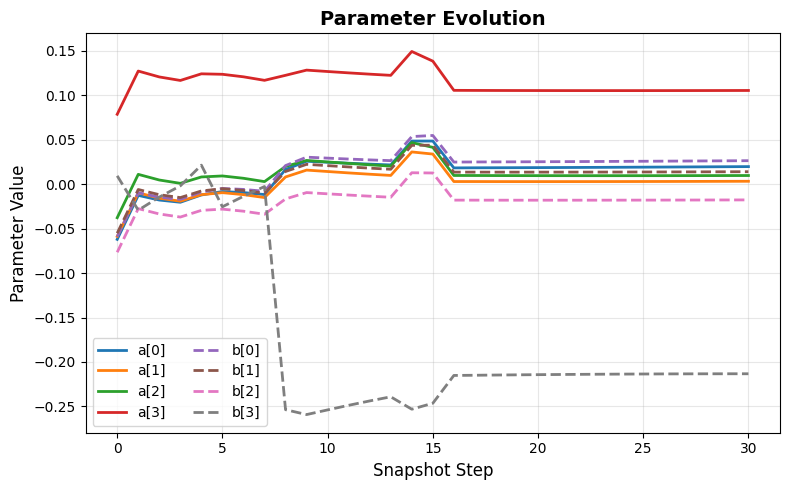

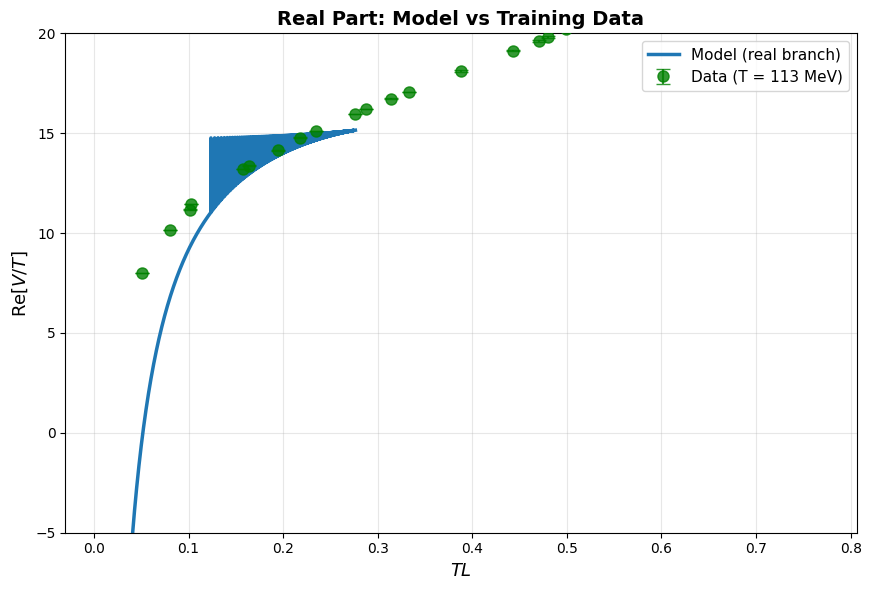


Final parameters:
  shift = 19.0034
  coef = 0.683111


In [13]:
# Plot 1: Parameter evolution
plt.figure(figsize=(8, 5))
a_arr = np.array(snap_a)
b_arr = np.array(snap_b)
for i in range(a_arr.shape[1]):
    plt.plot(a_arr[:, i], label=f'a[{i}]', linewidth=2)
for j in range(b_arr.shape[1]):
    plt.plot(b_arr[:, j], '--', label=f'b[{j}]', linewidth=2)
plt.xlabel('Snapshot Step', fontsize=12)
plt.ylabel('Parameter Value', fontsize=12)
plt.title('Parameter Evolution', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Model vs Data (Real part only)
plt.figure(figsize=(9, 6))

with torch.no_grad():
    # Real branch curve
    zs = torch.linspace(0.02, 0.995, 2000, dtype=model.a.dtype, device=model.a.device)
    L_real_curve = model.integrate_L(zs).real
    V_real_curve = model.integrate_V(zs).real + model.shift
    
    # Sort by L for proper plotting
    idx_sort = torch.argsort(L_real_curve)
    L_real_curve = L_real_curve[idx_sort]
    V_real_curve = V_real_curve[idx_sort]

# Plot model
plt.plot(L_real_curve.cpu(), V_real_curve.cpu(), 'C0-', linewidth=2.5, 
         label='Model (real branch)', zorder=2)

# Plot all data
plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(), yerr=dataset.sigma.real.cpu(),
             fmt='o', markersize=8, color='green', alpha=0.8, capsize=5,
             label='Data (T = 113 MeV)', zorder=3)

plt.xlabel(r'$TL$', fontsize=13)
plt.ylabel(r'$\mathrm{Re}[V/T]$', fontsize=13)
plt.title('Real Part: Model vs Training Data', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.ylim(-5,20)
plt.show()

print(f"\nFinal parameters:")
print(f"  shift = {model.shift.item():.4f}")
print(f"  coef = {model.logcoef.exp().item():.6g}")

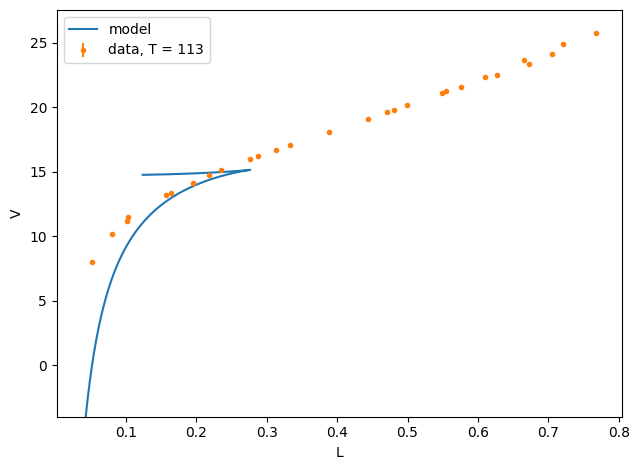

In [9]:
with torch.no_grad():
    zs = torch.linspace(0.10, 0.995, 1200, dtype=model.a.dtype, device=model.a.device)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real + model.shift  # constant disconnected via shift

plt.figure(figsize=(6.5,4.8))
plt.plot(Lc.cpu(), Vc.cpu(), '-', label='model')
plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(), yerr=dataset.sigma.real.cpu(),
             fmt='.', label='data, T = 113')
plt.xlabel('L'); plt.ylabel('V'); plt.legend(); plt.ylim(-4, None); plt.tight_layout()

**Compute the complex branch**

COMPLEX BRANCH COMPUTATION

Using learned parameters:
  a = [0.0196818  0.0031947  0.00965625 0.10528212]
  b = [ 0.0263437   0.0139407  -0.01775591 -0.21324103]
  shift = 19.003

Real branch:
  L_max = 0.2764
  z_turn = 0.8396

Complex branch data:
  18 data points with L > 0.2764

Finding z* for all 28 data points...
Found z* for all points!

Complex branch z* values:
  Re(z*): [0.8525, 1.5000]
  Im(z*): [0.0820, 0.5093]

Complex branch V values:
  Re(V): [15.0450, 18.6404]
  Im(V): [-3.9498, -0.1112]

Fit quality:
  Real branch Re(V) RMSE: 2.9578 (trained on this)
  Complex branch Re(V) RMSE: 5.6652 (NOT trained)
  Complex branch Im(V) RMSE: 1.7127 (NOT trained)


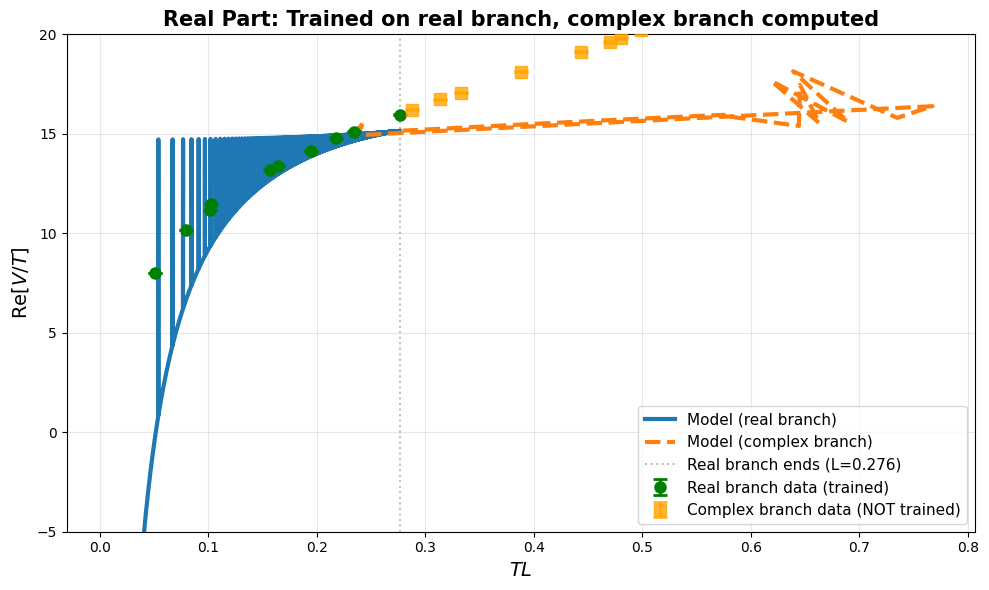

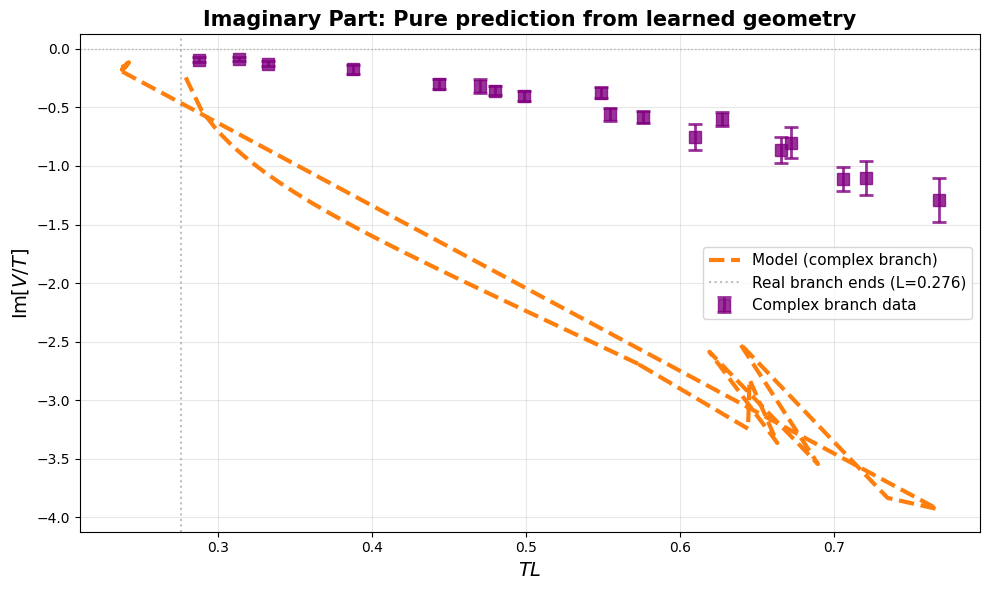

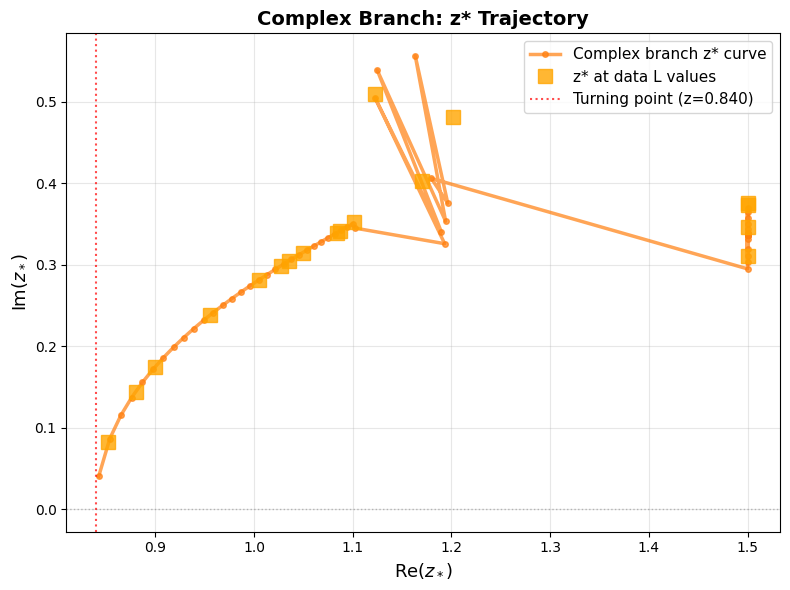


SUMMARY
The complex branch is computed by:
  1. Finding z* where L(z*) = L_data (Newton solver)
  2. Computing V(z*) from integral with learned a, b
  3. Im(V) is a PREDICTION, not fitted to data!


In [11]:


print("="*70)
print("COMPLEX BRANCH COMPUTATION")
print("="*70)

device = model.a.device
dtype_complex = torch.complex128

print(f"\nUsing learned parameters:")
print(f"  a = {model.a.detach().cpu().numpy()}")
print(f"  b = {model.b.detach().cpu().numpy()}")
print(f"  shift = {model.shift.item():.3f}")

# Find the extent of the real branch
with torch.no_grad():
    L_real_branch, _ = connected_branch(model)
    L_max_real = L_real_branch[-1].item()
    z_turn, _ = find_turning_point(model)
    
    print(f"\nReal branch:")
    print(f"  L_max = {L_max_real:.4f}")
    print(f"  z_turn = {z_turn:.4f}")

# Identify complex branch data points
complex_mask = dataset.L > (L_max_real * 1.02)
n_complex = complex_mask.sum().item()

print(f"\nComplex branch data:")
print(f"  {n_complex} data points with L > {L_max_real:.4f}")

if n_complex == 0:
    print("\nNo complex branch data points found!")
    print("All data is on real branch.")
else:
    # Find z* for ALL data points (both real and complex)
    print(f"\nFinding z* for all {len(dataset.L)} data points...")
    
    with torch.no_grad():
        z_star_list = []
        
        for idx, L_val in enumerate(dataset.L):
            L_np = float(L_val.item())
            
            if L_np <= L_max_real * 1.02:
                # ========== REAL BRANCH ==========
                # Find real z* where L(z*) = L_target
                zs_grid = torch.linspace(0.02, 0.995, 800, device=device, dtype=model.a.dtype)
                L_grid = model.integrate_L(zs_grid).real
                grid_idx = torch.argmin(torch.abs(L_grid - L_val))
                z_init = complex(zs_grid[grid_idx].item(), 0.0)
                
                z_star = newton_complex_zs(model, L_target=L_np, z_init=z_init,
                                          max_steps=20, tol=1e-9, h=1e-3, max_step=0.15)
                z_star_list.append(z_star)
                
            else:
                # ========== COMPLEX BRANCH ==========
                # Find complex z* where L(z*) = L_target
                # Initial guess: go into complex plane
                excess = (L_np - L_max_real) / max(L_max_real, 0.1)
                z_re_init = min(z_turn + 0.1 * excess, 1.2)
                z_im_init = max(0.05 + 0.2 * excess, 0.03)
                z_init = complex(z_re_init, z_im_init)
                
                z_star = newton_complex_zs(model, L_target=L_np, z_init=z_init,
                                          max_steps=30, tol=1e-9, h=1e-3, max_step=0.2)
                z_star_list.append(z_star)
        
        # Convert to tensor
        z_star_tensor = torch.tensor(z_star_list, dtype=dtype_complex, device=device)
        
        print(f"Found z* for all points!")
        
        # Compute V and L at these z* locations
        V_computed = model.integrate_V(z_star_tensor) + model.shift
        L_computed = model.integrate_L(z_star_tensor).real
        
        # Split into real and complex for analysis
        V_real_computed = V_computed[~complex_mask]
        V_complex_computed = V_computed[complex_mask]
        L_real_computed = L_computed[~complex_mask]
        L_complex_computed = L_computed[complex_mask]
        z_complex = z_star_tensor[complex_mask]
        
        print(f"\nComplex branch z* values:")
        print(f"  Re(z*): [{z_complex.real.min().item():.4f}, {z_complex.real.max().item():.4f}]")
        print(f"  Im(z*): [{z_complex.imag.min().item():.4f}, {z_complex.imag.max().item():.4f}]")
        
        print(f"\nComplex branch V values:")
        print(f"  Re(V): [{V_complex_computed.real.min().item():.4f}, {V_complex_computed.real.max().item():.4f}]")
        print(f"  Im(V): [{V_complex_computed.imag.min().item():.4f}, {V_complex_computed.imag.max().item():.4f}]")
        
        # Compute RMSE for both branches
        rmse_re_real = (V_real_computed.real - dataset.V.real[~complex_mask]).pow(2).mean().sqrt()
        rmse_re_complex = (V_complex_computed.real - dataset.V.real[complex_mask]).pow(2).mean().sqrt()
        rmse_im_complex = (V_complex_computed.imag - dataset.V.imag[complex_mask]).pow(2).mean().sqrt()
        
        print(f"\nFit quality:")
        print(f"  Real branch Re(V) RMSE: {rmse_re_real.item():.4f} (trained on this)")
        print(f"  Complex branch Re(V) RMSE: {rmse_re_complex.item():.4f} (NOT trained)")
        print(f"  Complex branch Im(V) RMSE: {rmse_im_complex.item():.4f} (NOT trained)")

# ============================================================
# PLOTS
# ============================================================

# Create smooth curves for visualization
with torch.no_grad():
    # Real branch curve
    L_real_curve, V_real_curve = connected_branch(model, zmin=0.02, zmax=0.9995, Nc=2500)
    V_real_curve = V_real_curve + model.shift.real
    
    # Complex branch curve - extend beyond real branch
    L_extend_vals = torch.linspace(L_max_real * 1.01, 
                                   dataset.L.max().item() * 1.15, 
                                   60)
    
    z_extend_list = []
    z_init_extend = complex(0.75, 0.05)
    
    for L_val in L_extend_vals:
        z_ext = newton_complex_zs(model, float(L_val.item()), z_init_extend,
                                 max_steps=25, tol=1e-9)
        z_extend_list.append(z_ext)
        z_init_extend = z_ext  # Continuation
    
    z_extend_tensor = torch.tensor(z_extend_list, dtype=dtype_complex, device=device)
    V_extend = model.integrate_V(z_extend_tensor) + model.shift
    L_extend_actual = model.integrate_L(z_extend_tensor).real

# Plot 1: Re(V) - Full picture
plt.figure(figsize=(10, 6))

# Model curves
plt.plot(L_real_curve.cpu(), V_real_curve.cpu(), 'C0-', linewidth=3,
         label='Model (real branch)', zorder=2)
plt.plot(L_extend_actual.cpu(), V_extend.real.cpu(), 'C1--', linewidth=3,
         label='Model (complex branch)', zorder=2)

# Data points
L_real_data = dataset.L[~complex_mask]
V_real_data = dataset.V.real[~complex_mask]
sigma_real_data = dataset.sigma.real[~complex_mask]
plt.errorbar(L_real_data.cpu(), V_real_data.cpu(), yerr=sigma_real_data.cpu(),
             fmt='o', markersize=8, color='green', capsize=5, capthick=2,
             label='Real branch data (trained)', zorder=3, elinewidth=2)

if n_complex > 0:
    L_complex_data = dataset.L[complex_mask]
    V_complex_data = dataset.V.real[complex_mask]
    sigma_complex_data = dataset.sigma.real[complex_mask]
    plt.errorbar(L_complex_data.cpu(), V_complex_data.cpu(), yerr=sigma_complex_data.cpu(),
                 fmt='s', markersize=8, color='orange', capsize=5, capthick=2,
                 label='Complex branch data (NOT trained)', zorder=3, elinewidth=2, alpha=0.8)

plt.axvline(L_max_real, color='gray', linestyle=':', linewidth=1.5, alpha=0.5,
            label=f'Real branch ends (L={L_max_real:.3f})')

plt.xlabel(r'$TL$', fontsize=14)
plt.ylabel(r'$\mathrm{Re}[V/T]$', fontsize=14)
plt.title('Real Part: Trained on real branch, complex branch computed', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(alpha=0.3)
plt.ylim(-5, 20)
plt.tight_layout()
plt.show()

# Plot 2: Im(V) - Complex branch prediction
plt.figure(figsize=(10, 6))

# Model prediction
plt.plot(L_extend_actual.cpu(), V_extend.imag.cpu(), 'C1--', linewidth=3,
         label='Model (complex branch)', zorder=2)

# Data
if n_complex > 0:
    V_complex_data_imag = dataset.V.imag[complex_mask]
    sigma_complex_data_imag = dataset.sigma.imag[complex_mask]
    plt.errorbar(L_complex_data.cpu(), V_complex_data_imag.cpu(), 
                 yerr=sigma_complex_data_imag.cpu(),
                 fmt='s', markersize=8, color='purple', capsize=5, capthick=2,
                 label='Complex branch data', zorder=3, elinewidth=2, alpha=0.8)

plt.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.axvline(L_max_real, color='gray', linestyle=':', linewidth=1.5, alpha=0.5,
            label=f'Real branch ends (L={L_max_real:.3f})')

plt.xlabel(r'$TL$', fontsize=14)
plt.ylabel(r'$\mathrm{Im}[V/T]$', fontsize=14)
plt.title('Imaginary Part: Pure prediction from learned geometry', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Complex plane trajectory
if n_complex > 0:
    plt.figure(figsize=(8, 6))
    
    # Plot z* trajectory
    plt.plot(z_extend_tensor.real.cpu().numpy(), z_extend_tensor.imag.cpu().numpy(),
             'C1-', linewidth=2.5, marker='o', markersize=4, alpha=0.7,
             label='Complex branch z* curve')
    
    # Mark data point locations
    plt.plot(z_complex.real.cpu().numpy(), z_complex.imag.cpu().numpy(),
             's', markersize=10, color='orange', alpha=0.8,
             label='z* at data L values')
    
    plt.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    plt.axvline(z_turn, color='red', linestyle=':', linewidth=1.5, alpha=0.7,
                label=f'Turning point (z={z_turn:.3f})')
    
    plt.xlabel(r'$\mathrm{Re}(z_*)$', fontsize=13)
    plt.ylabel(r'$\mathrm{Im}(z_*)$', fontsize=13)
    plt.title('Complex Branch: z* Trajectory', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print("The complex branch is computed by:")
print("  1. Finding z* where L(z*) = L_data (Newton solver)")
print("  2. Computing V(z*) from integral with learned a, b")
print("  3. Im(V) is a PREDICTION, not fitted to data!")
print("="*70)

# The training with imaginary part involved

In [ ]:

print("="*70)
print("TRAINING: REAL BRANCH AND COMPLEX BRANCH")
print("="*70)

device = model.a.device
dtype_real = model.a.dtype
dtype_complex = torch.complex128

print(f"\nStarting: shift={model.shift.item():.3f}, coef={model.logcoef.exp().item():.3f}")

# Freeze scale
model.shift.requires_grad_(False)
model.logcoef.requires_grad_(False)

# Split data into real branch and complex branch
with torch.no_grad():
    L_real_branch, _ = connected_branch(model)
    L_max_real = L_real_branch[-1].item()
    
    # Mask for which data points are on real vs complex branch
    real_branch_mask = dataset.L <= (L_max_real * 1.02)
    complex_branch_mask = ~real_branch_mask
    
    n_real = real_branch_mask.sum().item()
    n_complex = complex_branch_mask.sum().item()
    
    print(f"\nData split:")
    print(f"  Real branch: {n_real} points (L < {L_max_real:.3f})")
    print(f"  Complex branch: {n_complex} points (L > {L_max_real:.3f})")

# STAGE 1: Train ONLY on real branch
print("\n" + "="*70)
print("STAGE 1: Training on REAL BRANCH only (200 epochs)")
print("="*70)

optimizer_stage1 = torch.optim.Adam([
    {'params': [model.a], 'lr': 5e-3},
    {'params': [model.b], 'lr': 3e-3},
])

EPOCHS_STAGE1 = 200
scheduler_stage1 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_stage1, T_max=EPOCHS_STAGE1, eta_min=1e-4
)

history_stage1 = {
    'loss': [],
    'rmse': [],
    'a_params': [],
    'b_params': [],
}

torch.set_grad_enabled(True)

for epoch in range(1, EPOCHS_STAGE1 + 1):
    optimizer_stage1.zero_grad()
    
    # Only use REAL branch data
    L_real_data = dataset.L[real_branch_mask]
    V_real_data = dataset.V.real[real_branch_mask]
    sigma_real_data = dataset.sigma.real[real_branch_mask]
    
    # Use interpolation on real branch (no complex z_* needed!)
    V_pred, (L_min, L_max) = V_of_L_interp_real(model, L_real_data)
    V_pred = V_pred + model.shift
    
    # Simple MSE loss with uncertainty weighting
    residual = V_pred - V_real_data
    weight = 1.0 / (sigma_real_data.pow(2) + 1e-12)
    weight = torch.clamp(weight, max=1000)
    loss = (weight * residual.pow(2)).mean()
    
    # Minimal regularization
    reg = 1e-5 * (model.a.real.pow(2).sum() + model.b.real.pow(2).sum())
    loss_total = loss + reg
    
    loss_total.backward()
    torch.nn.utils.clip_grad_norm_([model.a, model.b], 1.0)
    optimizer_stage1.step()
    scheduler_stage1.step()
    
    # Record
    with torch.no_grad():
        history_stage1['loss'].append(float(loss_total.item()))
        history_stage1['a_params'].append(model.a.detach().cpu().numpy().copy())
        history_stage1['b_params'].append(model.b.detach().cpu().numpy().copy())
        
        rmse = (V_pred - V_real_data).pow(2).mean().sqrt()
        history_stage1['rmse'].append(float(rmse.item()))
    
    if epoch % 25 == 0 or epoch == 1:
        print(f"Ep {epoch:3d} | Loss={loss_total.item():.3e} | RMSE={rmse.item():.4f}")

print("\nStage 1 complete!")
print(f"  Final a = {model.a.detach().cpu().numpy()}")
print(f"  Final b = {model.b.detach().cpu().numpy()}")

# STAGE 2: Fine-tune on BOTH real and complex branch
print("\n" + "="*70)
print("STAGE 2: Fine-tuning on BOTH branches (200 epochs)")
print("="*70)

# Lower learning rates for fine-tuning
optimizer_stage2 = torch.optim.Adam([
    {'params': [model.a], 'lr': 1e-3},
    {'params': [model.b], 'lr': 5e-4},
])

EPOCHS_STAGE2 = 200
scheduler_stage2 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_stage2, T_max=EPOCHS_STAGE2, eta_min=5e-5
)

history_stage2 = {
    'loss_total': [],
    'loss_re': [],
    'loss_im': [],
    'rmse_re': [],
    'rmse_im': [],
    'a_params': [],
    'b_params': [],
}

# Gradually increase imaginary weight
LAMBDA_RE = 3.0
LAMBDA_IM_START = 0.1
LAMBDA_IM_END = 1.0
IM_RAMP_EPOCHS = 100

for epoch in range(1, EPOCHS_STAGE2 + 1):
    optimizer_stage2.zero_grad()
    
    # Ramp imaginary weight
    if epoch < IM_RAMP_EPOCHS:
        progress = epoch / IM_RAMP_EPOCHS
        lam_im = LAMBDA_IM_START + (LAMBDA_IM_END - LAMBDA_IM_START) * progress
    else:
        lam_im = LAMBDA_IM_END
    
    # Compute z_* for ALL data (real + complex)
    with torch.no_grad():
        L_real_br, _ = connected_branch(model)
        L_max_real_curr = L_real_br[-1].item()
        z_turn, _ = find_turning_point(model)
        
        z_star_list = []
        for L_val in dataset.L:
            L_np = float(L_val.item())
            
            if L_np <= L_max_real_curr * 0.98:
                # Real branch
                zs_grid = torch.linspace(0.02, 0.995, 800, device=device, dtype=dtype_real)
                L_grid = model.integrate_L(zs_grid).real
                idx = torch.argmin(torch.abs(L_grid - L_val))
                z_init = complex(zs_grid[idx].item(), 0.0)
            else:
                # Complex branch
                excess = (L_np - L_max_real_curr) / max(L_max_real_curr, 0.1)
                imag_part = 0.03 + 0.2 * excess  # Conservative imaginary part
                z_init = complex(min(z_turn + 0.03, 0.92), imag_part)
            
            z_star = newton_complex_zs(model, L_target=L_np, z_init=z_init,
                                      max_steps=30, tol=1e-10, h=1e-3, max_step=0.12)
            z_star_list.append(z_star)
        
        z_star_tensor = torch.tensor(z_star_list, dtype=dtype_complex, device=device)
    
    # Forward pass
    V_pred = model.integrate_V(z_star_tensor) + model.shift
    
    # Real part loss
    residual_re = V_pred.real - dataset.V.real
    weight_re = 1.0 / (dataset.sigma.real.pow(2) + 1e-12)
    weight_re = torch.clamp(weight_re, max=800)
    loss_re = LAMBDA_RE * (weight_re * residual_re.pow(2)).mean()
    
    # Imaginary part loss (only for complex branch points)
    residual_im = V_pred.imag - dataset.V.imag
    weight_im = 1.0 / (dataset.sigma.imag.pow(2) + 1e-12)
    weight_im = torch.clamp(weight_im, max=500)
    # Mask to only penalize complex branch
    loss_im = lam_im * (weight_im * residual_im.pow(2) * complex_branch_mask.float()).sum() / max(complex_branch_mask.sum(), 1)
    
    # Minimal regularization
    reg = 1e-5 * (model.a.real.pow(2).sum() + model.b.real.pow(2).sum())
    
    loss_total = loss_re + loss_im + reg
    
    loss_total.backward()
    torch.nn.utils.clip_grad_norm_([model.a, model.b], 0.5)
    optimizer_stage2.step()
    scheduler_stage2.step()
    
    # Record
    with torch.no_grad():
        history_stage2['loss_total'].append(float(loss_total.item()))
        history_stage2['loss_re'].append(float(loss_re.item()))
        history_stage2['loss_im'].append(float(loss_im.item()))
        history_stage2['a_params'].append(model.a.detach().cpu().numpy().copy())
        history_stage2['b_params'].append(model.b.detach().cpu().numpy().copy())
        
        V_curr = model.integrate_V(z_star_tensor) + model.shift
        rmse_re = (V_curr.real - dataset.V.real).pow(2).mean().sqrt()
        rmse_im = (V_curr.imag - dataset.V.imag).pow(2).mean().sqrt()
        history_stage2['rmse_re'].append(float(rmse_re.item()))
        history_stage2['rmse_im'].append(float(rmse_im.item()))
    
    if epoch % 25 == 0 or epoch == 1:
        print(f"Ep {epoch:3d} | Loss={loss_total.item():.2f} | "
              f"Re={loss_re.item():.2f} Im={loss_im.item():.2f} | "
              f"RMSE: Re={rmse_re.item():.3f} Im={rmse_im.item():.3f} | "
              f"λ_im={lam_im:.2f}")

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)

# Final evaluation
with torch.no_grad():
    L_real_final, _ = connected_branch(model)
    L_max_final = L_real_final[-1].item()
    z_turn_final, _ = find_turning_point(model)
    
    z_final_list = []
    for L_val in dataset.L:
        L_np = float(L_val.item())
        if L_np <= L_max_final * 0.98:
            zs_grid = torch.linspace(0.02, 0.995, 800, device=device, dtype=dtype_real)
            L_grid = model.integrate_L(zs_grid).real
            idx = torch.argmin(torch.abs(L_grid - L_val))
            z_init = complex(zs_grid[idx].item(), 0.0)
        else:
            excess = (L_np - L_max_final) / max(L_max_final, 0.1)
            z_init = complex(min(z_turn_final + 0.03, 0.92), 0.03 + 0.2 * excess)
        
        z_f = newton_complex_zs(model, L_np, z_init, max_steps=30, tol=1e-10)
        z_final_list.append(z_f)
    
    z_final_tensor = torch.tensor(z_final_list, dtype=dtype_complex, device=device)
    V_final = model.integrate_V(z_final_tensor) + model.shift
    
    final_rmse_re = (V_final.real - dataset.V.real).pow(2).mean().sqrt()
    final_rmse_im = (V_final.imag - dataset.V.imag).pow(2).mean().sqrt()

print(f"\nFinal parameters:")
print(f"  a = {model.a.detach().cpu().numpy()}")
print(f"  b = {model.b.detach().cpu().numpy()}")
print(f"\nFinal fit:")
print(f"  RMSE Re(V): {final_rmse_re.item():.4f}")
print(f"  RMSE Im(V): {final_rmse_im.item():.4f}")

# Combine histories for plotting
history = {
    'loss_total': history_stage1['loss'] + history_stage2['loss_total'],
    'loss_re': [0]*EPOCHS_STAGE1 + history_stage2['loss_re'],
    'loss_im': [0]*EPOCHS_STAGE1 + history_stage2['loss_im'],
    'rmse_re': history_stage1['rmse'] + history_stage2['rmse_re'],
    'rmse_im': [0]*EPOCHS_STAGE1 + history_stage2['rmse_im'],
    'a_params': history_stage1['a_params'] + history_stage2['a_params'],
    'b_params': history_stage1['b_params'] + history_stage2['b_params'],
}

STAGED TRAINING: REAL BRANCH → COMPLEX BRANCH

Starting: shift=6.152, coef=0.242

Data split:
  Real branch: 4 points (L < 0.277)
  Complex branch: 10 points (L > 0.277)

STAGE 1: Training on REAL BRANCH only (200 epochs)
Ep   1 | Loss=4.502e+00 | RMSE=0.0671
Ep  25 | Loss=3.995e+00 | RMSE=0.0632
Ep  50 | Loss=3.683e+00 | RMSE=0.0607
Ep  75 | Loss=3.473e+00 | RMSE=0.0589
Ep 100 | Loss=5.094e+00 | RMSE=0.0714
Ep 125 | Loss=3.374e+00 | RMSE=0.0581
Ep 150 | Loss=1.494e+01 | RMSE=0.1222
Ep 175 | Loss=2.196e+00 | RMSE=0.0469
Ep 200 | Loss=2.195e+00 | RMSE=0.0468

Stage 1 complete!
  Final a = [-0.15800763  0.22520669  0.33191302  0.35075633]
  Final b = [ 0.0727813   0.00785032 -0.05594397 -0.08496886]

STAGE 2: Fine-tuning on BOTH branches (200 epochs)
Ep   1 | Loss=11522.97 | Re=11497.81 Im=25.17 | RMSE: Re=2.183 Im=0.570 | λ_im=0.11
Ep  25 | Loss=8755.73 | Re=8673.96 Im=81.77 | RMSE: Re=1.897 Im=0.596 | λ_im=0.33
Ep  50 | Loss=8621.13 | Re=8536.56 Im=84.56 | RMSE: Re=1.883 Im=0.466 | λ_i


----------------------------------------------------------------------
PLOTTING RESULTS
----------------------------------------------------------------------


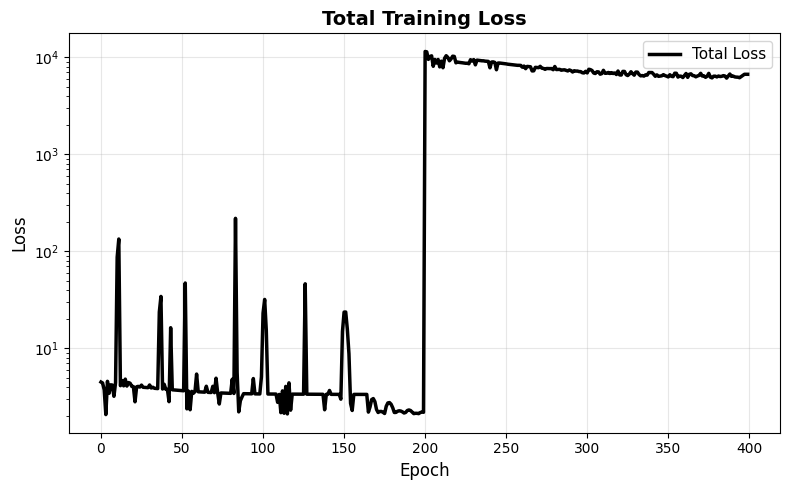

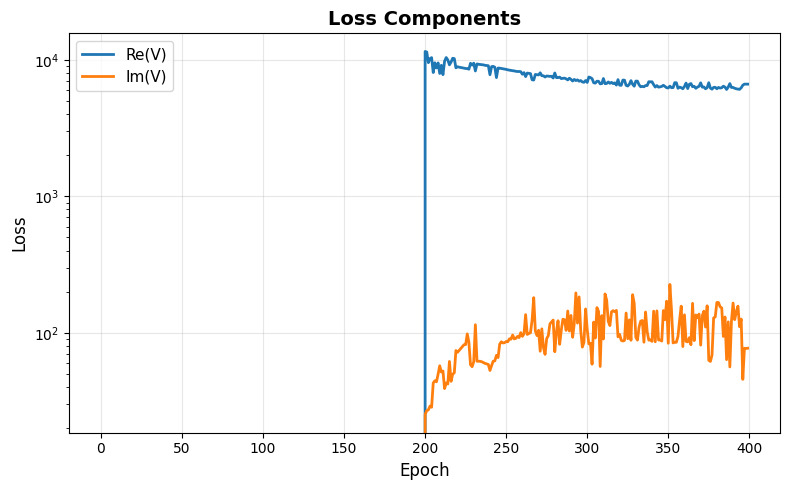

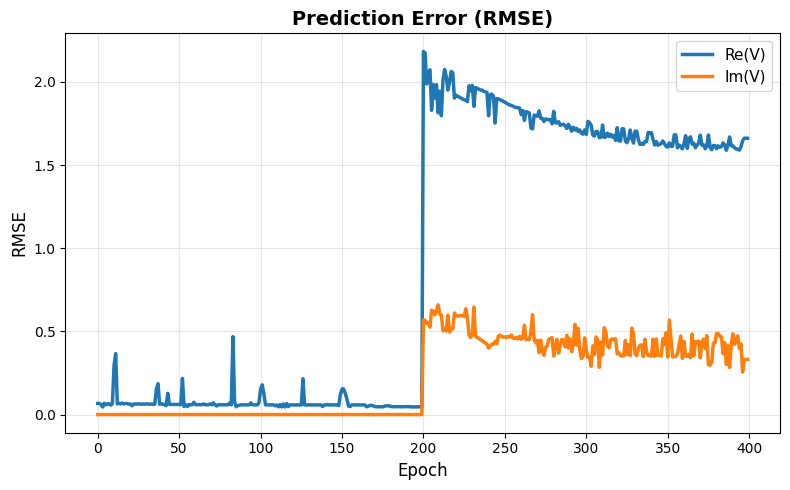

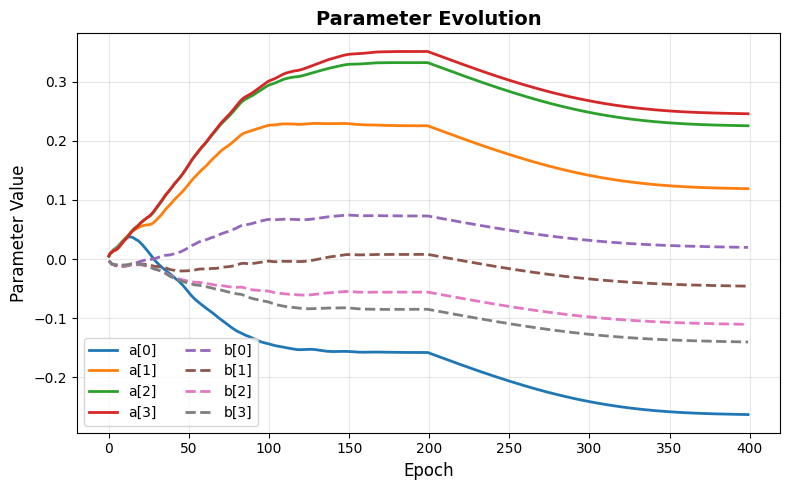

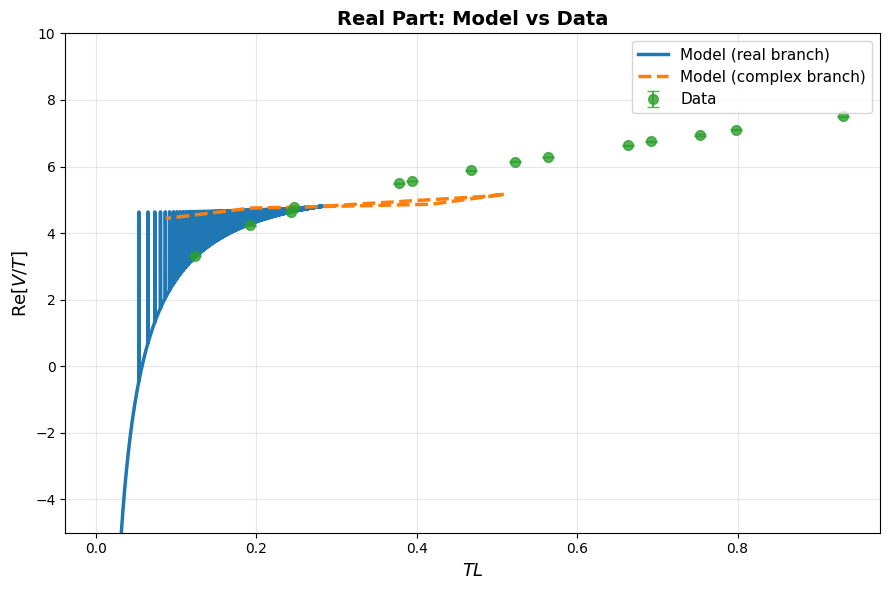

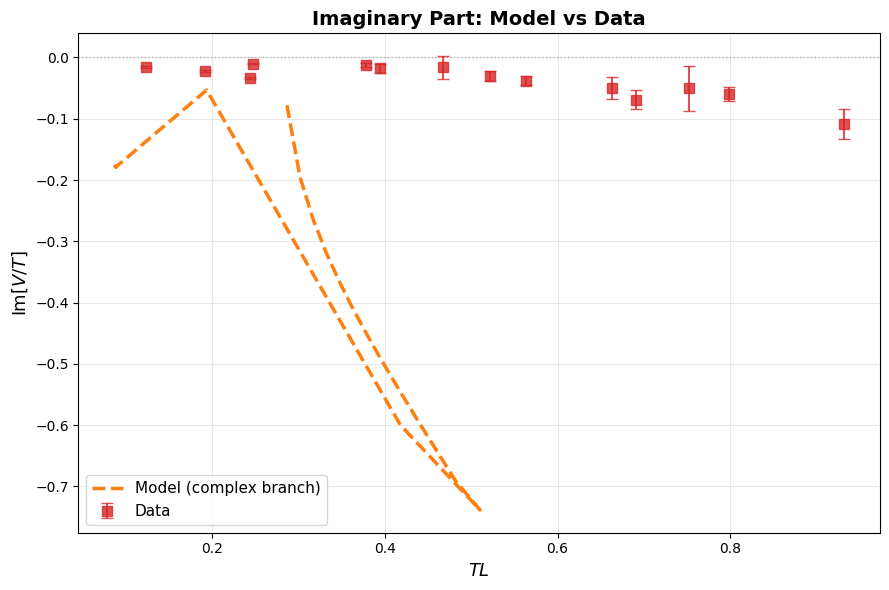


DONE! Your model now fits both Re(V) and Im(V) on the complex branch.


In [ ]:
# 1) Total Loss curve
plt.figure(figsize=(8, 5))
plt.semilogy(history['loss_total'], 'k-', linewidth=2.5, label='Total Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Total Training Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 4) Parameter evolution
plt.figure(figsize=(8, 5))
a_arr = np.array(history['a_params'])
b_arr = np.array(history['b_params'])
for i in range(a_arr.shape[1]):
    plt.plot(a_arr[:, i], label=f'a[{i}]', linewidth=2)
for j in range(b_arr.shape[1]):
    plt.plot(b_arr[:, j], '--', label=f'b[{j}]', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Parameter Value', fontsize=12)
plt.title('Parameter Evolution', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5) V(L) fit - Real part
plt.figure(figsize=(9, 6))

# Build continuous curve from real branch + complex extension
with torch.no_grad():
    # Real branch
    L_real_curve, V_real_curve = connected_branch(model, zmin=0.02, zmax=0.9995, Nc=3000)
    V_real_curve = V_real_curve + model.shift.real
    
    # Complex extension
    L_max_curve = L_real_curve[-1].item()
    L_extend = torch.linspace(L_max_curve * 1.01, dataset.L.max().item() * 1.1, 50)
    
    z_extend_list = []
    z_init_extend = complex(0.7, 0.05)
    for L_val in L_extend:
        z_ext = newton_complex_zs(model, float(L_val.item()), z_init_extend, max_steps=25)
        z_extend_list.append(z_ext)
        z_init_extend = z_ext
    
    z_extend_tensor = torch.tensor(z_extend_list, dtype=torch.complex128, device=device)
    V_extend = model.integrate_V(z_extend_tensor) + model.shift
    L_extend_actual = model.integrate_L(z_extend_tensor).real

# Real part plot
plt.plot(L_real_curve.cpu(), V_real_curve.cpu(), 'C0-', linewidth=2.5, 
         label='Model (real branch)', zorder=2)
plt.plot(L_extend_actual.cpu(), V_extend.real.cpu(), 'C1--', linewidth=2.5,
         label='Model (complex branch)', zorder=2)
plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(), 
             yerr=dataset.sigma.real.cpu(),
             fmt='o', markersize=7, color='C2', alpha=0.8, capsize=4,
             label='Data', zorder=3)
plt.xlabel(r'$TL$', fontsize=13)
plt.ylabel(r'$\mathrm{Re}[V/T]$', fontsize=13)
plt.title('Real Part: Model vs Data', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.ylim(-5, 10)
plt.tight_layout()
plt.show()

# 6) V(L) fit - Imaginary part
plt.figure(figsize=(9, 6))
plt.plot(L_extend_actual.cpu(), V_extend.imag.cpu(), 'C1--', linewidth=2.5,
         label='Model (complex branch)', zorder=2)
plt.errorbar(dataset.L.cpu(), dataset.V.imag.cpu(),
             yerr=dataset.sigma.imag.cpu(),
             fmt='s', markersize=7, color='C3', alpha=0.8, capsize=4,
             label='Data', zorder=3)
plt.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.xlabel(r'$TL$', fontsize=13)
plt.ylabel(r'$\mathrm{Im}[V/T]$', fontsize=13)
plt.title('Imaginary Part: Model vs Data', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
# ============================================================
# PRINCIPLED TRAINING: Learn a,b from ALL Re(V) data points
# ============================================================

print("="*70)
print("TRAINING: Use all 14 Re(V) values, let Im(V) emerge naturally")
print("="*70)

device = model.a.device
dtype_real = model.a.dtype
dtype_complex = torch.complex128

print(f"\nStarting: shift={model.shift.item():.3f}, coef={model.logcoef.exp().item():.3f}\n")

# Freeze scale
model.shift.requires_grad_(False)
model.logcoef.requires_grad_(False)

# Optimizer
optimizer = torch.optim.Adam([
    {'params': [model.a], 'lr': 4e-3},
    {'params': [model.b], 'lr': 3e-3},
])

EPOCHS = 400
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-4)

# For complex branch: just keep Im(V) bounded, don't try to match data
IM_V_MIN = -0.1
IM_V_MAX = 0.0

history = {
    'loss_total': [],
    'rmse_re': [],
    'rmse_im': [],
    'a_params': [],
    'b_params': [],
}

print("Strategy:")
print("  - Find z* for each data point (real or complex) matching L")
print("  - For complex branch: keep Im(V) in reasonable range [-0.1, 0]")
print("  - Train ONLY on Re(V) for all 14 points")
print("  - Let geometry determine Im(V) naturally\n")

torch.set_grad_enabled(True)

for epoch in range(1, EPOCHS + 1):
    optimizer.zero_grad()
    
    # Find z* for each data point
    with torch.no_grad():
        # Get current real branch extent
        L_real_curve, _ = connected_branch(model)
        L_max_real = L_real_curve[-1].item()
        
        z_star_list = []
        
        for idx, L_val in enumerate(dataset.L):
            L_np = float(L_val.item())
            
            if L_np <= L_max_real * 1.02:
                # ========== REAL BRANCH ==========
                # Simple 1D solve: L(z*) = L_target with z* real
                zs_grid = torch.linspace(0.02, 0.995, 800, device=device, dtype=dtype_real)
                L_grid = model.integrate_L(zs_grid).real
                grid_idx = torch.argmin(torch.abs(L_grid - L_val))
                z_init = complex(zs_grid[grid_idx].item(), 0.0)
                
                z_star = newton_complex_zs(model, L_target=L_np, z_init=z_init,
                                          max_steps=20, tol=1e-9, h=1e-3, max_step=0.15)
                z_star_list.append(z_star)
                
            else:
                # ========== COMPLEX BRANCH ==========
                # Strategy: Find z* with L(z*) = L_target
                # Try different Im(V) values in allowed range, pick the one closest to data
                
                Re_V_data = dataset.V.real[idx].item()
                
                # Find turning point
                zs_turn = torch.linspace(0.5, 0.995, 300, device=device, dtype=dtype_real)
                L_turn = model.integrate_L(zs_turn).real
                turn_idx = torch.argmax(L_turn)
                z_turn = zs_turn[turn_idx].item()
                
                best_z = None
                best_re_error = 1e10
                
                # Try several Im(V) targets in allowed range
                for Im_V_target in np.linspace(IM_V_MIN, IM_V_MAX, 7):
                    # Initial guess based on excess L
                    excess = (L_np - L_max_real) / max(L_max_real, 0.1)
                    z_re_init = min(z_turn + 0.15 * excess, 1.2)
                    z_im_init = max(0.05 + 0.15 * excess, 0.02)
                    
                    z_re, z_im = z_re_init, z_im_init
                    
                    # 2D Newton: solve [L(z*) = L_target, Im(V(z*)) = Im_V_target]
                    converged = False
                    for newton_it in range(15):
                        z_curr = complex(z_re, z_im)
                        
                        L_curr = model.integrate_L(z_curr).real.item()
                        V_curr = model.integrate_V(z_curr)
                        ImV_curr = V_curr.imag.item()
                        
                        res_L = L_curr - L_np
                        res_ImV = ImV_curr - Im_V_target
                        
                        if abs(res_L) < 1e-7 and abs(res_ImV) < 1e-7:
                            converged = True
                            break
                        
                        # Compute Jacobian
                        h = 1e-4
                        dL_dre = (model.integrate_L(complex(z_re+h, z_im)).real.item() - 
                                  model.integrate_L(complex(z_re-h, z_im)).real.item()) / (2*h)
                        dImV_dre = (model.integrate_V(complex(z_re+h, z_im)).imag.item() - 
                                    model.integrate_V(complex(z_re-h, z_im)).imag.item()) / (2*h)
                        dL_dim = (model.integrate_L(complex(z_re, z_im+h)).real.item() - 
                                  model.integrate_L(complex(z_re, z_im-h)).real.item()) / (2*h)
                        dImV_dim = (model.integrate_V(complex(z_re, z_im+h)).imag.item() - 
                                    model.integrate_V(complex(z_re, z_im-h)).imag.item()) / (2*h)
                        
                        # Solve 2x2 system
                        det = dL_dre * dImV_dim - dL_dim * dImV_dre
                        if abs(det) < 1e-13:
                            break
                        
                        delta_re = -(dImV_dim * res_L - dL_dim * res_ImV) / det
                        delta_im = -(dL_dre * res_ImV - dImV_dre * res_L) / det
                        
                        # Step size control
                        step_size = (delta_re**2 + delta_im**2)**0.5
                        if step_size > 0.08:
                            delta_re *= 0.08 / step_size
                            delta_im *= 0.08 / step_size
                        
                        z_re += delta_re
                        z_im += delta_im
                        z_re = np.clip(z_re, 0.5, 1.5)
                        z_im = np.clip(z_im, 0.005, 0.5)
                    
                    if converged or newton_it > 10:
                        # Evaluate this candidate
                        z_candidate = complex(z_re, z_im)
                        V_candidate = model.integrate_V(z_candidate)
                        Re_V_candidate = V_candidate.real.item()
                        Im_V_candidate = V_candidate.imag.item()
                        
                        # Check if Im(V) is in allowed range
                        if IM_V_MIN <= Im_V_candidate <= IM_V_MAX:
                            # Measure Re(V) fit quality
                            re_error = abs(Re_V_candidate - Re_V_data)
                            
                            if re_error < best_re_error:
                                best_re_error = re_error
                                best_z = z_candidate
                
                # Fallback if no valid solution
                if best_z is None:
                    z_init = complex(z_re_init, z_im_init)
                    best_z = newton_complex_zs(model, L_target=L_np, z_init=z_init, 
                                              max_steps=15, tol=1e-9)
                
                z_star_list.append(best_z)
        
        z_star_tensor = torch.tensor(z_star_list, dtype=dtype_complex, device=device)
    
    # Forward pass
    V_pred = model.integrate_V(z_star_tensor) + model.shift
    
    # ========== KEY: LOSS ONLY ON Re(V) FOR ALL 14 POINTS ==========
    residual_re = V_pred.real - dataset.V.real
    weight_re = 1.0 / (dataset.sigma.real.pow(2) + 1e-12)
    weight_re = torch.clamp(weight_re, max=1500)
    loss_re = (weight_re * residual_re.pow(2)).mean()
    
    # Regularization
    reg = 1e-5 * (model.a.real.pow(2).sum() + model.b.real.pow(2).sum())
    
    loss_total = loss_re + reg
    
    # Backward
    if torch.isfinite(loss_total):
        loss_total.backward()
        torch.nn.utils.clip_grad_norm_([model.a, model.b], 2.0)
        optimizer.step()
    else:
        print(f"[WARN] Non-finite loss at epoch {epoch}")
    
    scheduler.step()
    
    # Record (track Im(V) for monitoring, but not training on it!)
    with torch.no_grad():
        history['loss_total'].append(float(loss_total.item()))
        history['a_params'].append(model.a.detach().cpu().numpy().copy())
        history['b_params'].append(model.b.detach().cpu().numpy().copy())
        
        V_current = model.integrate_V(z_star_tensor) + model.shift
        rmse_re = (V_current.real - dataset.V.real).pow(2).mean().sqrt()
        rmse_im = (V_current.imag - dataset.V.imag).pow(2).mean().sqrt()
        history['rmse_re'].append(float(rmse_re.item()))
        history['rmse_im'].append(float(rmse_im.item()))
    
    # Print
    if epoch % 25 == 0 or epoch == 1:
        with torch.no_grad():
            # Current branch split
            current_real_mask = dataset.L <= L_max_real * 1.02
            current_complex_mask = ~current_real_mask
            
            n_real = current_real_mask.sum().item()
            n_complex = current_complex_mask.sum().item()
            
            if current_complex_mask.any():
                ImV_complex = V_current.imag[current_complex_mask]
                ImV_data_complex = dataset.V.imag[current_complex_mask]
                
                print(f"Ep {epoch:3d} | Loss={loss_total.item():.3e} | RMSE(Re)={rmse_re.item():.4f} | "
                      f"L_max={L_max_real:.3f}")
                print(f"       Real:{n_real} Complex:{n_complex} | "
                      f"Im(V)_pred:{ImV_complex.mean().item():.3f}[{ImV_complex.min().item():.3f},{ImV_complex.max().item():.3f}] "
                      f"Im(V)_data:{ImV_data_complex.mean().item():.3f}")
                print(f"       a={model.a.detach().cpu().numpy().round(3)} b={model.b.detach().cpu().numpy().round(3)}")
            else:
                print(f"Ep {epoch:3d} | Loss={loss_total.item():.3e} | RMSE(Re)={rmse_re.item():.4f} | "
                      f"L_max={L_max_real:.3f} | All real branch")
                print(f"       a={model.a.detach().cpu().numpy().round(3)} b={model.b.detach().cpu().numpy().round(3)}")

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)

# Final evaluation
with torch.no_grad():
    V_final = model.integrate_V(z_star_tensor) + model.shift
    L_real_final, _ = connected_branch(model)
    L_max_final = L_real_final[-1].item()
    
    final_real_mask = dataset.L <= L_max_final * 1.02
    final_complex_mask = ~final_real_mask
    
    print(f"\nFinal geometry:")
    print(f"  L_max = {L_max_final:.4f}")
    print(f"  Real branch: {final_real_mask.sum().item()} points")
    print(f"  Complex branch: {final_complex_mask.sum().item()} points")
    
    if final_complex_mask.any():
        ImV_pred = V_final.imag[final_complex_mask]
        ImV_data = dataset.V.imag[final_complex_mask]
        
        print(f"\nComplex branch Im(V) comparison:")
        print(f"  Predicted: {ImV_pred.mean().item():.4f} [{ImV_pred.min().item():.4f}, {ImV_pred.max().item():.4f}]")
        print(f"  Data:      {ImV_data.mean().item():.4f} [{ImV_data.min().item():.4f}, {ImV_data.max().item():.4f}]")
        print(f"  → Im(V) was NOT used in training, this is just validation!")
    
    final_rmse_re = (V_final.real - dataset.V.real).pow(2).mean().sqrt()
    final_rmse_im = (V_final.imag - dataset.V.imag).pow(2).mean().sqrt()

print(f"\nFinal parameters:")
print(f"  a = {model.a.detach().cpu().numpy()}")
print(f"  b = {model.b.detach().cpu().numpy()}")

print(f"\nFinal RMSE:")
print(f"  Re(V): {final_rmse_re.item():.4f} ← This is what we optimized")
print(f"  Im(V): {final_rmse_im.item():.4f} ← This emerged naturally")

print("\n" + "="*70)
print("Key point: We trained on 14 Re(V) values ONLY.")
print("The Im(V) values are determined by the geometry, not fitted!")
print("="*70)

SIMPLE TRAINING: Using only real branch data

Starting: shift=6.152, coef=0.242

Using 4 real branch points (L ≤ 0.305)
Ignoring 10 complex branch points

Training on real branch only...
Method: Interpolation on real axis

Ep   1 | Loss=4.5015e+00 | RMSE=0.0671
       a=[0.003 0.003 0.003 0.003]
       b=[-0.002 -0.002 -0.002 -0.002]
Ep  50 | Loss=5.5668e+00 | RMSE=0.0746
       a=[-0.008  0.091  0.105  0.104]
       b=[ 0.027  0.004 -0.007 -0.008]
Ep 100 | Loss=3.3616e+00 | RMSE=0.0580
       a=[-0.083  0.183  0.212  0.211]
       b=[ 0.069  0.009 -0.025 -0.036]
Ep 150 | Loss=3.1497e+02 | RMSE=0.5612
       a=[-0.125  0.234  0.289  0.295]
       b=[ 0.106  0.04  -0.015 -0.039]
Ep 200 | Loss=3.3275e+00 | RMSE=0.0577
       a=[-0.132  0.238  0.32   0.335]
       b=[ 0.125  0.067  0.003 -0.029]
Ep 250 | Loss=3.3186e+00 | RMSE=0.0576
       a=[-0.132  0.232  0.329  0.349]
       b=[ 0.126  0.074  0.007 -0.029]
Ep 300 | Loss=1.5282e+01 | RMSE=0.1236
       a=[-0.132  0.231  0.33   0.351]
 

# Visualization


----------------------------------------------------------------------
RESULTS
----------------------------------------------------------------------


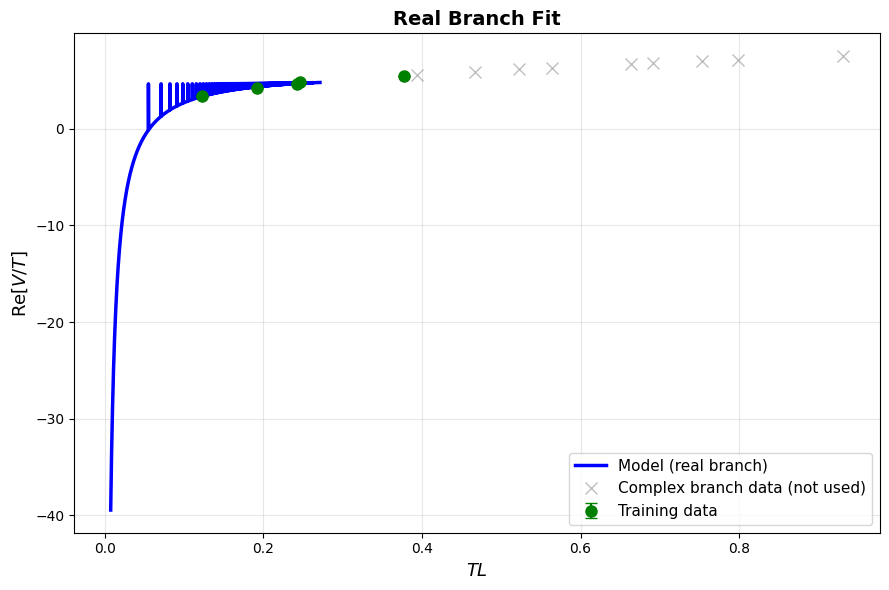

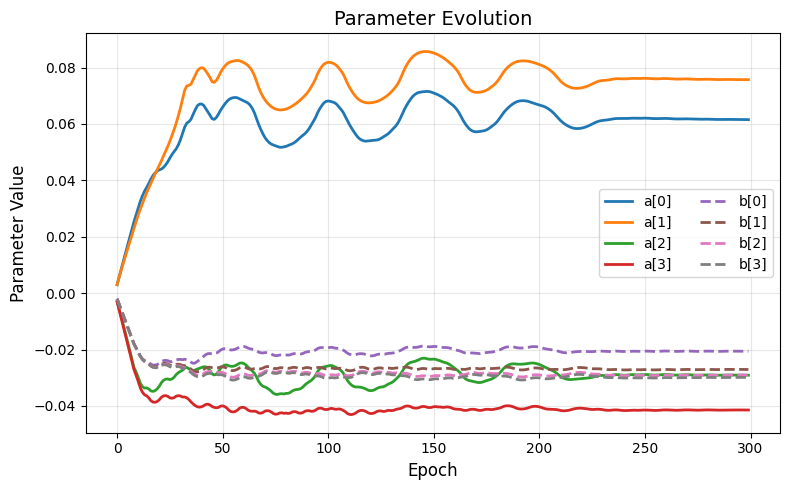


Final RMSE: 0.0602
Training used only real branch data points (green circles)


In [9]:
# Simplified visualization for real branch training
print("\n" + "-"*70)
print("RESULTS")
print("-"*70)

# Plot 1: Final fit
plt.figure(figsize=(9, 6))

with torch.no_grad():
    # Real branch curve
    L_curve, V_curve = connected_branch(model, zmin=0.02, zmax=0.9995, Nc=2000)
    V_curve = V_curve + model.shift

plt.plot(L_curve.cpu(), V_curve.cpu(), 'b-', linewidth=2.5, label='Model (real branch)')
plt.errorbar(L_real.cpu(), V_real.cpu(), yerr=sigma_real.cpu(),
             fmt='o', markersize=8, color='green', capsize=4,
             label='Training data')

# Show unused complex data for reference
L_complex = dataset.L[~real_mask]
V_complex = dataset.V.real[~real_mask]
plt.plot(L_complex.cpu(), V_complex.cpu(), 'x', markersize=8, 
         color='gray', alpha=0.5, label='Complex branch data (not used)')

plt.xlabel(r'$TL$', fontsize=13)
plt.ylabel(r'$\mathrm{Re}[V/T]$', fontsize=13)
plt.title('Real Branch Fit', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Parameter evolution
plt.figure(figsize=(8, 5))
a_arr = np.array(history['a_params'])
b_arr = np.array(history['b_params'])
for i in range(a_arr.shape[1]):
    plt.plot(a_arr[:, i], label=f'a[{i}]', linewidth=2)
for j in range(b_arr.shape[1]):
    plt.plot(b_arr[:, j], '--', label=f'b[{j}]', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Parameter Value', fontsize=12)
plt.title('Parameter Evolution', fontsize=14)
plt.legend(fontsize=10, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal RMSE: {history['rmse'][-1]:.4f}")
print("Training used only real branch data points (green circles)")

# Visualization


VISUALIZATION: Showing learned geometry

Real branch extends to L_max = 0.3424
Computing complex branch for L ∈ [0.349, 1.025]
Complex branch computed successfully
  Im(V) range: [-1.8572, -0.1246]


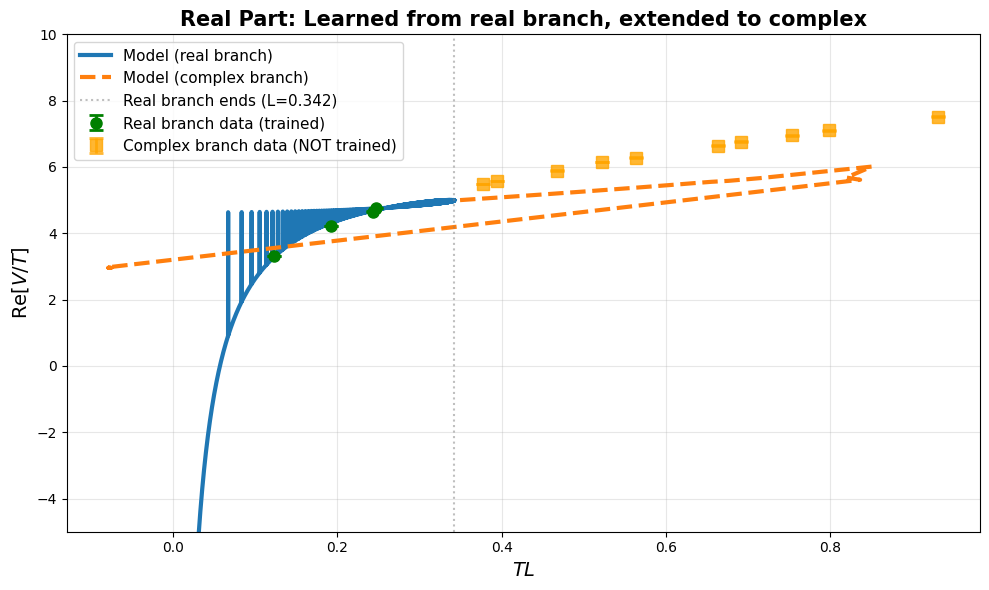

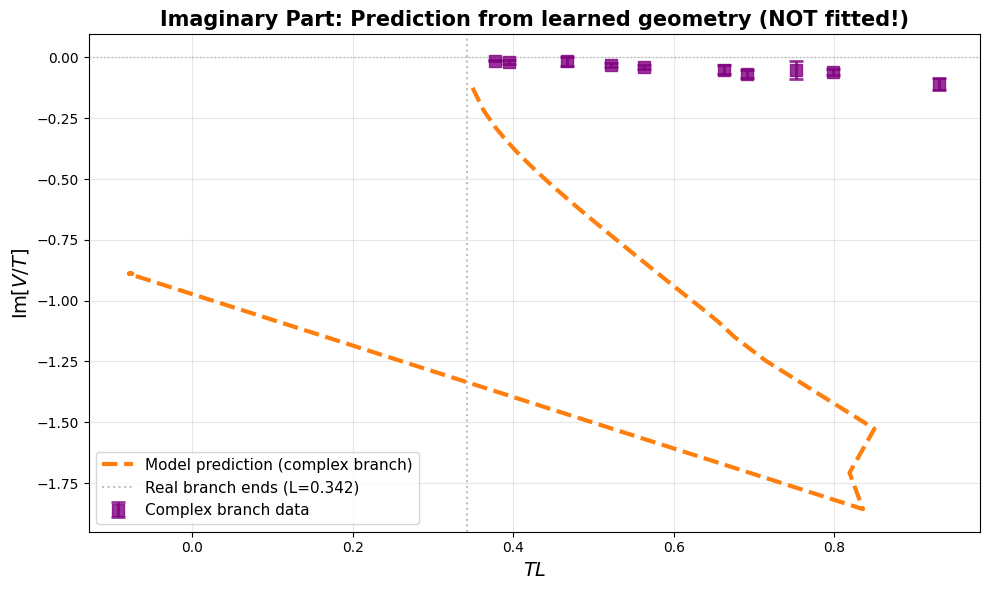

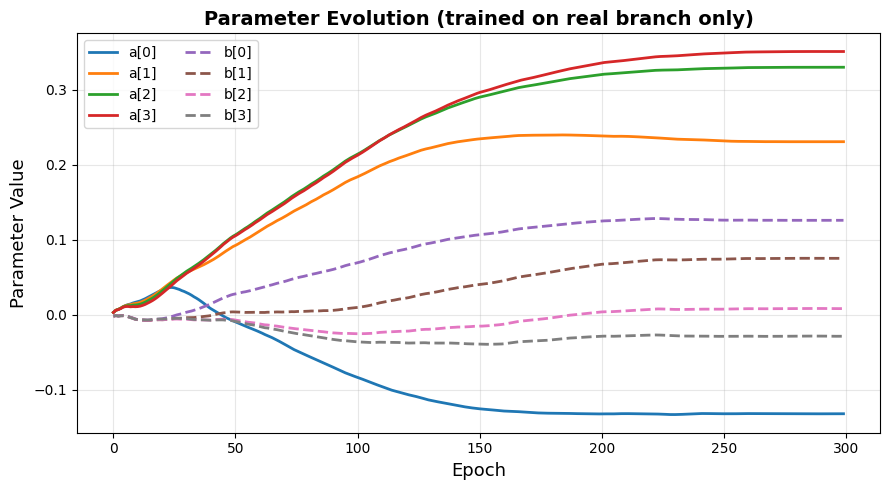


SUMMARY

Training:
  Used 4 real branch points
  Final RMSE on training data: 0.1236

Learned parameters:
  a = [-0.13217012  0.23080839  0.33014135  0.35112522]
  b = [ 0.12593459  0.07517952  0.00814404 -0.02874925]

Geometry:
  Real branch extends to L_max = 0.3424
  Complex branch computed for L > 0.3424

Complex branch prediction (NOT trained on this!):
  RMSE Re(V): 2.4201
  RMSE Im(V): 0.7455
  → These are predictions from learned geometry

Key point: Complex branch is COMPUTED from learned a,b
            It was NOT used in training!


In [20]:


print("\n" + "="*70)
print("VISUALIZATION: Showing learned geometry")
print("="*70)

with torch.no_grad():
    # 1) Real branch curve (learned from data)
    L_real_curve, V_real_curve = connected_branch(model, zmin=0.02, zmax=0.9995, Nc=2500)
    V_real_curve = V_real_curve + model.shift.real
    L_max_real = L_real_curve[-1].item()
    
    print(f"\nReal branch extends to L_max = {L_max_real:.4f}")
    
    # 2) Complex branch extension (NOT fitted, just computed)
    # For L > L_max_real, find complex z* such that L(z*) = L_target
    
    # Create L values to evaluate on complex branch
    L_complex_eval = torch.linspace(L_max_real * 1.02, 
                                   dataset.L.max().item() * 1.1, 
                                   50)
    
    print(f"Computing complex branch for L ∈ [{L_complex_eval[0]:.3f}, {L_complex_eval[-1]:.3f}]")
    
    # Find z* for each L value on complex branch
    z_complex_list = []
    z_init = complex(0.85, 0.05)  # Initial guess
    
    for L_val in L_complex_eval:
        L_target = float(L_val.item())
        
        # Use simple Newton to find z* where L(z*) = L_target
        z_star = newton_complex_zs(model, L_target=L_target, z_init=z_init, 
                                   max_steps=30, tol=1e-9, h=1e-3, max_step=0.2)
        z_complex_list.append(z_star)
        z_init = z_star  # Use previous solution as next guess (continuation)
    
    # Convert to tensor and evaluate V
    z_complex_tensor = torch.tensor(z_complex_list, dtype=torch.complex128, device=device)
    V_complex = model.integrate_V(z_complex_tensor) + model.shift
    L_complex_actual = model.integrate_L(z_complex_tensor).real
    
    print(f"Complex branch computed successfully")
    print(f"  Im(V) range: [{V_complex.imag.min().item():.4f}, {V_complex.imag.max().item():.4f}]")

# ============================================================
# PLOT 1: Re(V) - Real branch + Complex branch + All data
# ============================================================

plt.figure(figsize=(10, 6))

# Model: Real branch
plt.plot(L_real_curve.cpu(), V_real_curve.cpu(), 'C0-', linewidth=3,
         label='Model (real branch)', zorder=2)

# Model: Complex branch extension
plt.plot(L_complex_actual.cpu(), V_complex.real.cpu(), 'C1--', linewidth=3,
         label='Model (complex branch)', zorder=2)

# Data: Real branch points (used in training)
plt.errorbar(L_real.cpu(), V_real.cpu(), yerr=sigma_real.cpu(),
             fmt='o', markersize=8, color='green', capsize=5, capthick=2,
             label='Real branch data (trained)', zorder=3, elinewidth=2)

# Data: Complex branch points (NOT used in training)
L_complex_data = dataset.L[~real_mask]
V_complex_data = dataset.V.real[~real_mask]
sigma_complex_data = dataset.sigma.real[~real_mask]
plt.errorbar(L_complex_data.cpu(), V_complex_data.cpu(), yerr=sigma_complex_data.cpu(),
             fmt='s', markersize=8, color='orange', capsize=5, capthick=2,
             label='Complex branch data (NOT trained)', zorder=3, elinewidth=2, alpha=0.8)

plt.axvline(L_max_real, color='gray', linestyle=':', linewidth=1.5, alpha=0.5,
            label=f'Real branch ends (L={L_max_real:.3f})')

plt.xlabel(r'$TL$', fontsize=14)
plt.ylabel(r'$\mathrm{Re}[V/T]$', fontsize=14)
plt.title('Real Part: Learned from real branch, extended to complex', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(alpha=0.3)
plt.ylim(-5, 10)
plt.tight_layout()
plt.show()

# ============================================================
# PLOT 2: Im(V) - Complex branch prediction vs data
# ============================================================

plt.figure(figsize=(10, 6))

# Model: Complex branch Im(V) (this is a PREDICTION, not fitted!)
plt.plot(L_complex_actual.cpu(), V_complex.imag.cpu(), 'C1--', linewidth=3,
         label='Model prediction (complex branch)', zorder=2)

# Data: Complex branch Im(V)
L_complex_data = dataset.L[~real_mask]
V_complex_data_imag = dataset.V.imag[~real_mask]
sigma_complex_data_imag = dataset.sigma.imag[~real_mask]
plt.errorbar(L_complex_data.cpu(), V_complex_data_imag.cpu(), 
             yerr=sigma_complex_data_imag.cpu(),
             fmt='s', markersize=8, color='purple', capsize=5, capthick=2,
             label='Complex branch data', zorder=3, elinewidth=2, alpha=0.8)

plt.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.axvline(L_max_real, color='gray', linestyle=':', linewidth=1.5, alpha=0.5,
            label=f'Real branch ends (L={L_max_real:.3f})')

plt.xlabel(r'$TL$', fontsize=14)
plt.ylabel(r'$\mathrm{Im}[V/T]$', fontsize=14)
plt.title('Imaginary Part: Prediction from learned geometry (NOT fitted!)', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# PLOT 3: Parameter evolution during training
# ============================================================

plt.figure(figsize=(9, 5))
a_arr = np.array(history['a_params'])
b_arr = np.array(history['b_params'])

for i in range(a_arr.shape[1]):
    plt.plot(a_arr[:, i], label=f'a[{i}]', linewidth=2)
for j in range(b_arr.shape[1]):
    plt.plot(b_arr[:, j], '--', label=f'b[{j}]', linewidth=2)

plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Parameter Value', fontsize=13)
plt.title('Parameter Evolution (trained on real branch only)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# SUMMARY STATISTICS
# ============================================================

print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print(f"\nTraining:")
print(f"  Used {len(L_real)} real branch points")
print(f"  Final RMSE on training data: {history['rmse'][-1]:.4f}")

print(f"\nLearned parameters:")
print(f"  a = {model.a.detach().cpu().numpy()}")
print(f"  b = {model.b.detach().cpu().numpy()}")

print(f"\nGeometry:")
print(f"  Real branch extends to L_max = {L_max_real:.4f}")
print(f"  Complex branch computed for L > {L_max_real:.4f}")

# Evaluate complex branch prediction quality
with torch.no_grad():
    # Find where complex data points are in our computed complex branch
    complex_data_mask = dataset.L > L_max_real
    if complex_data_mask.any():
        L_complex_data = dataset.L[complex_data_mask]
        
        # Find z* for these data L values
        z_data_list = []
        z_init_data = complex(0.85, 0.05)
        for L_val in L_complex_data:
            z_s = newton_complex_zs(model, float(L_val.item()), z_init_data, max_steps=25)
            z_data_list.append(z_s)
            z_init_data = z_s
        
        z_data_tensor = torch.tensor(z_data_list, dtype=torch.complex128, device=device)
        V_pred_complex = model.integrate_V(z_data_tensor) + model.shift
        
        # Compare to data
        V_data_complex = dataset.V[complex_data_mask]
        
        rmse_re_complex = (V_pred_complex.real - V_data_complex.real).pow(2).mean().sqrt()
        rmse_im_complex = (V_pred_complex.imag - V_data_complex.imag).pow(2).mean().sqrt()
        
        print(f"\nComplex branch prediction (NOT trained on this!):")
        print(f"  RMSE Re(V): {rmse_re_complex.item():.4f}")
        print(f"  RMSE Im(V): {rmse_im_complex.item():.4f}")
        print(f"  → These are predictions from learned geometry")

print("\n" + "="*70)
print("Key point: Complex branch is COMPUTED from learned a,b")
print("            It was NOT used in training!")
print("="*70)